In [1]:
import numpy as np
import mrcfile
import math
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib import rc
from scipy import ndimage as nd
from scipy.stats import norm 
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit
from tabulate import tabulate

In [7]:
path = "/Users/fabiankohler/Dropbox (DIETZ LAB)/PROJEKTE/Corner Study/Corner45/CSv3/Cryo/MB-Analysis/MB415_composite/"

prefix = ''
filename_map = 'composite_cutoutmasked_map.mrc'
filename_locres = 'CSv3_consensus-vs-MB415-composite-by-preMBcutouts_difference-locres.mrc'
threshold_map = 0.05

In [8]:
def read_mrc(filename):
    with mrcfile.open(filename, mode='r') as mrc:
        data = mrc.data.transpose()
        m_o = np.array(mrc.header["origin"])
        m_origin = np.array([m_o["x"], m_o["y"], m_o["z"]])
        m_c = np.array(mrc.header["cella"])
        m_cell = np.array([m_c["x"], m_c["y"], m_c["z"]])
        m_grid = np.array([mrc.header["nx"], mrc.header["ny"], mrc.header["nz"]])
        m_spacing = m_cell/m_grid
        return data, m_origin, m_cell, m_grid, m_spacing
    
class EMmap:
    
    def __init__(self, filename_map, filename_locres, threshold):
        self.filename_map = filename_map
        self.filename_locres = filename_locres
        self.threshold = threshold
        self.read_map()
        self.read_locres()
        self.create_mask()
        self.mask_locres()
        self.locres_statistics()       
    
        
    def read_map(self):
        filename = path + filename_map
        self.map_data, self.map_origin, self.map_cell, self.map_grid, self.map_spacing = read_mrc(filename)
        
        
    def read_locres(self):
        filename = path + filename_locres
        self.locres_data, self.locres_origin, self.locres_cell, self.locres_grid, self.locres_spacing = read_mrc(filename)
        
        
    def create_mask(self):
        map_data = self.map_data
        threshold = self.threshold
        self.mask = np.where(map_data > threshold, 1, 0)
        
    def mask_locres(self):
        mask = self.mask
        locres = self.locres_data
        masked = np.multiply(mask, locres)
        flat = masked.flatten()
        zeroesremoved = flat[flat != 0]
        self.masked_locres_data = masked
        self.masked_locres_data_flattened_nonzero = zeroesremoved

        
    def locres_statistics(self):
        locres = self.masked_locres_data_flattened_nonzero
        self.resolution_average = np.average(locres)    
        self.resolution_stddev = np.std(locres)        
        self.resolution_minimum = locres.min()
        self.resolution_maximum = locres.max()
        self.resolution_percentile_5 = np.percentile(locres, 5)
        self.resolution_percentile_95 = np.percentile(locres, 95)
        
        self.resolution_stddev_2decimals = round(self.resolution_stddev, 2)
        self.resolution_average_2decimals = round(self.resolution_average, 2)
        self.resolution_minimum_2decimals = round(self.resolution_minimum, 2)
        self.resolution_maximum_2decimals = round(self.resolution_maximum, 2)
        self.resolution_percentile_5_2decimals = round(self.resolution_percentile_5, 2)
        self.resolution_percentile_95_2decimals = round(self.resolution_percentile_95, 2)

In [9]:
structure = EMmap(filename_map = filename_map, filename_locres = filename_map, threshold = threshold_map)

from tabulate import tabulate
data=[]
new_data = [structure.resolution_average_2decimals,
                structure.resolution_stddev_2decimals,
                structure.resolution_minimum_2decimals,
                structure.resolution_maximum_2decimals,
                structure.resolution_percentile_5_2decimals,
                structure.resolution_percentile_95_2decimals,]
data.append(new_data)
print (tabulate(data, headers=["Average", "StdDev", "Minimum", "Maximum", "5th percentile", "95th percentile"]))

  Average    StdDev    Minimum    Maximum    5th percentile    95th percentile
---------  --------  ---------  ---------  ----------------  -----------------
     0.48      0.39      -0.72       2.75             -0.04               1.18


Text(0.5, 1.0, 'Histogram ($\\mu = 0.48$, $\\sigma = 0.39$) and KDE of LocRes Improvement Distribution of CSv3_consensus-vs-MB415-composite-by-preMBcutouts_difference-locres\nwithin composite_cutoutmasked_map at a threshold of 0.05\n')

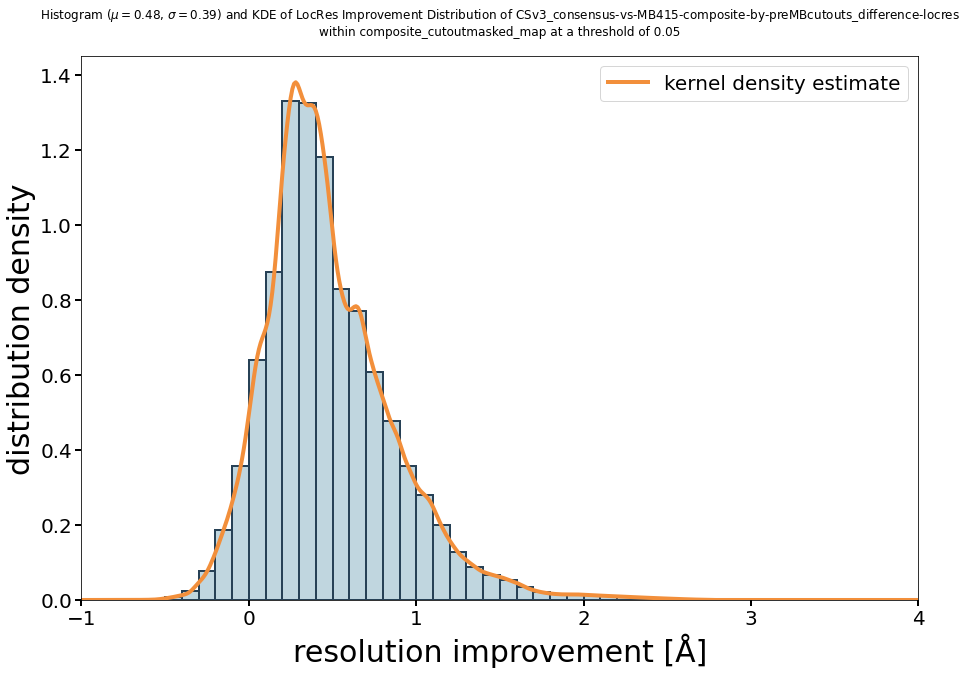

In [12]:
show_legend = True 

color_hist = "#c0d6df"
color_hist_edges = "#274156"
alpha_hist = 1
color_kde = "#f28f3b"
linewidth_hist = 2
linewidth_kde = 4
linewidth_percentiles = 4

hist_lower_limit = -1
hist_upper_limit = 4
bin_width_hist = 0.1
bin_width_kde = 0.01


hist_range = np.arange(hist_lower_limit, hist_upper_limit, bin_width_hist)

kde_range = np.arange(hist_lower_limit, hist_upper_limit, bin_width_kde)



plt.figure(figsize=(15,10))

plt.hist(structure.masked_locres_data_flattened_nonzero, hist_range, density=True,
         alpha = alpha_hist ,color=color_hist, edgecolor=color_hist_edges, linewidth=linewidth_hist) 
kde = gaussian_kde(structure.masked_locres_data_flattened_nonzero)
plt.plot(kde_range, kde(kde_range),label="kernel density estimate",linewidth=linewidth_kde,color=color_kde)   # with label for legend
 



if show_legend:
    plt.legend(loc='upper right', fontsize=20)

plt.xlabel("resolution improvement [Å]", fontsize=30)
plt.ylabel("distribution density", fontsize=30)
plt.xlim([hist_lower_limit,hist_upper_limit])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='out', length=6, width=2,)
plt.title('Histogram (' + 
          '$\mu = {}$, '.format(structure.resolution_average_2decimals) + 
          '$\sigma = {}$'.format(structure.resolution_stddev_2decimals) +
          ') and KDE of LocRes Improvement Distribution of {}{}\n'.format(prefix, filename_locres[0:-4]) +
          'within {} at a threshold of {}\n'.format(filename_map[0:-4], str(threshold_map)))

#plt.savefig(path + filename_locres[0:-4] +'_distribution-improvement-within{}-at0dot{}.pdf'.format(filename_map[0:-4],str(threshold_map)[2:]))  

